## Project 4: Advanced Lane Finding


### Camera Calibration

I calculated the distortion coefficients and camera matrix using the chessboard images in the camera_cal folder, there are 20 images in the folder. I implemented a for loop to go through each image in the folder using CV's findchesscorners function, this returned corners for 14 of the images, I then computed the camera calibration and distortion coefficients. The entire process described here is present in the calculate_distortion.ipynb file included in the submission. The returned coefficients were then stored in the distort.p pickle file. 

In [7]:
## import necessary packages
import preprocess as p

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
%matplotlib inline

#import distortion coefficients
distortion = pickle.load( open( "distort.p", "rb" ) )
mtx, dist = distortion["mtx"], distortion["dist"]


(-0.5, 1279.5, 719.5, -0.5)

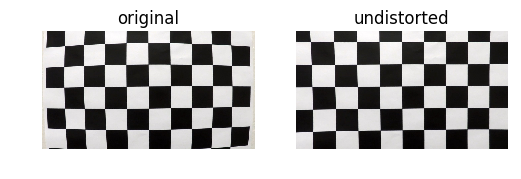

In [10]:
chess = mpimg.imread(os.path.join("camera_cal", "calibration1.jpg"))
undist = p.undistort(chess)


fig = plt.figure()
a=fig.add_subplot(1,2,1)
original = plt.imshow(chess)
a.set_title('original')
a.axis('off')

a=fig.add_subplot(1,2,2)
undistImage = plt.imshow(undist)
a.set_title('undistorted')
a.axis('off')

### Pipeline (test images)

Below is an example of a test image with undistortion correctly applied to it. 



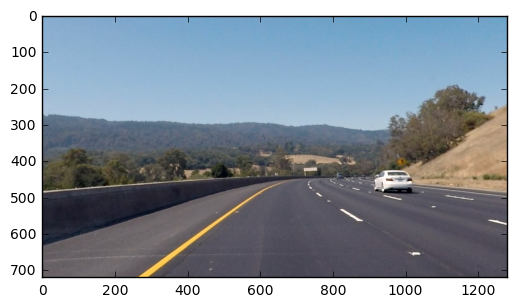

In [11]:
image = p.undistort(mpimg.imread(os.path.join("test_images", "test3.jpg")))
plt.imshow(image)

The part of applyting thresholds to identify lane lines was probably the hardest part of the entire project as it took a lot iterations and experimentation to get it right, or at least right enough. My strategy here was to first come up with a general strategy that would discover the kind of lanes that are easy enough to detect, and to then come up with thresholds to target the ones that can't be easily detected. The code for the entire thresholding is included in the preprocess.py file. 


The first part i looked into was the sobel operator, sobel is at the heart of canny edge detection and can be simply explained as taking the gradient in an image in a particular direction, in this case, it was taken in both directions and combined, this is contained in the preprocess file under the methods abs_sobel_thresh and sobel_combine from line 13 to line 50. 


The next part was to implement a number of color thresholds using RGB, YUV and HLS masks, a combination of all three combined in different ways was enough to get implement a general thresholding that could detect the lanes in most conditions. Two other methods were created, the van method for what I called the "vanishing white", this was especially effective in detecting white lanes in extra bright conditions that were starting to blend in with the environment, and the dark yellow, under the darkyellow method, this method was especially effective at capturing yellow lane lines when there're shadows across the lanes. The code covering the different color thresholds are in lines 73 - 178. 

(-0.5, 1279.5, 719.5, -0.5)

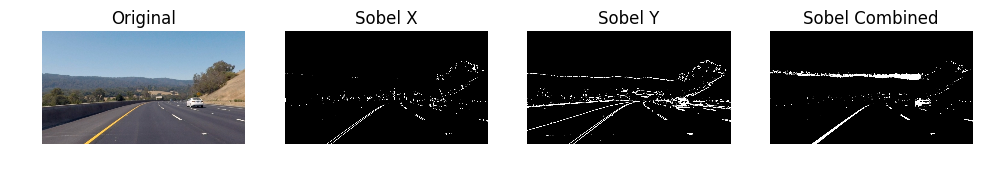

In [18]:


fig = plt.figure(figsize=(12,12))
a=fig.add_subplot(1,4,1)
original = plt.imshow(image)
a.set_title('Original')
a.axis('off')

a=fig.add_subplot(1,4,2)
undistImage = plt.imshow(p.abs_sobel_thresh(image, orient='x', thresh=(25, 205)), cmap='gray')
a.set_title('Sobel X')
a.axis('off')

a=fig.add_subplot(1,4,3)
original = plt.imshow(p.abs_sobel_thresh(image, orient='y', thresh=(25, 205)), cmap='gray')
a.set_title('Sobel Y')
a.axis('off')

a=fig.add_subplot(1,4,4)
undistImage = plt.imshow(p.combined_threshold(image), cmap='gray')
a.set_title('Sobel Combined')
a.axis('off')

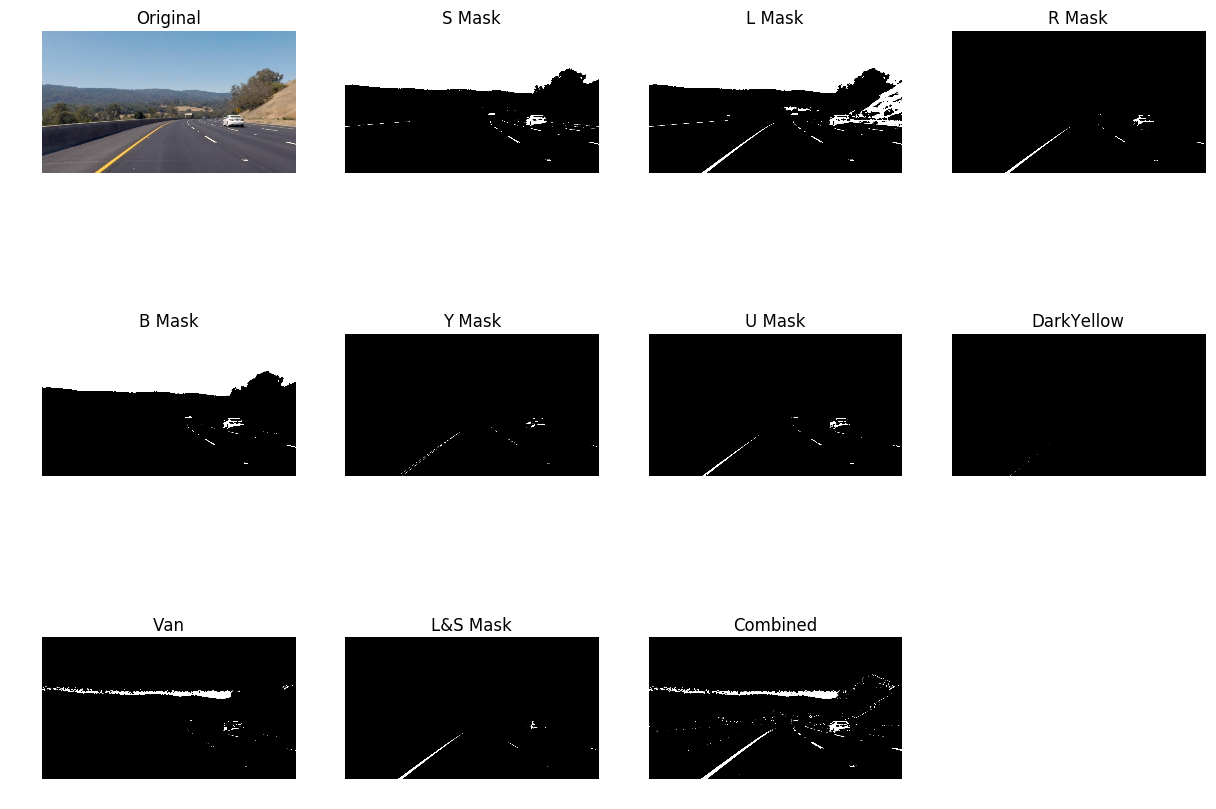

In [76]:
def helper(image, titles, size=15):
    fig = plt.figure(figsize=(size, size))
    for i in range(len(titles)):
        a=fig.add_subplot(4,4,i+1)
        plot = plt.imshow(image[i], cmap='gray')
        a.set_title(titles[i])
        a.axis('off')
        
titles = ["Original", "S Mask", "L Mask", "R Mask", "B Mask", "Y Mask", "U Mask", "DarkYellow", "Van", "L&S Mask", "Combined"]
images = [image, p.hlsMask(image), p.lMask(image), p.rMask(image), p.bMask(image), p.yMask(image), p.uMask(image), p.darkYellow(image), p.van(image), p.LandS(image), p.combined_threshold(image)]

helper(images, titles)

## Perspective Transform

I found this part of the project very interesting to be honest, I didn't really get it while watching the lectures but did while working on the project. The idea here is to transform the image to a bird's eye view where we can see the lane lines parallel (or at least as parallel as possible) so we can more easily calculate lane curvature. I igured out the source and destination points using a simple paint tool. The code for this is also located in the preprocess.py file in lines 195 - 204. This was implemented using CV's getPerspectiveTransform and warpPerspective functions. This resulted in - 

| Source(X,Y)  |Destination(X,Y)    |
|---|---|
| 570,458  | 100,100  |
| 720,460  | 1100,100  |
| 1233,710  | 1100,720  |
| 210,712  |  100,720 |

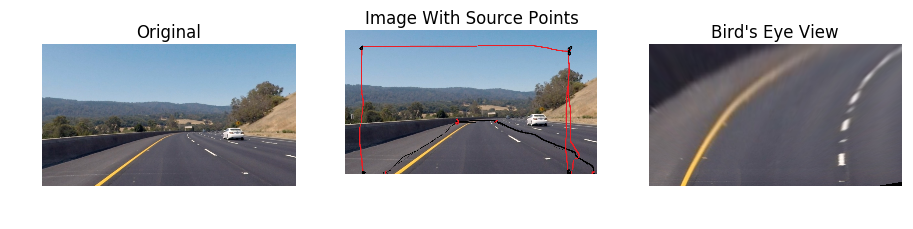

In [67]:
titles = ["Original", "Image With Source Points", "Bird's Eye View"]
images = [image, mpimg.imread(os.path.join("output_images", "perspective.png")), p.warp(image)]
helper(images, titles)

## Lane Line Detection

The code for this is present in the AdvanceLane.ipynb notebook file, this was implemented by only looking at the nonzero pixels of an image and using a sliding windows approach. This process takes a thresholded bird's eye view image which leaves us with a binary image, we start by looking at the bottom vertical half of the image, summing it up and checking for the max value, this gives us an idea of where to begin our search for lane lines, this is done by placing sliding windows around the line centers and searching upwards for line candidates. The code for this implementation is located in lines 6, 7 and 8 on the Advancelane.ipynb file. 

Additional implementations here include a function to search around previous detections rather than a blind search as was done the first time, additional protocols were put in place to reject lines that deviate too much from previous detections as well as smoothing the lanes over the past 8 good detections for a smoother process. 



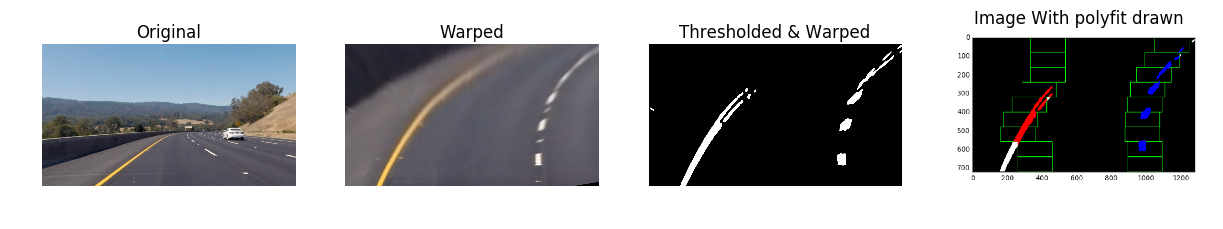

In [73]:
titles = ["Original", "Warped", "Thresholded & Warped", "Image With polyfit drawn"]
images = [image, p.warp(image), p.preprocess(image), mpimg.imread(os.path.join("output_images", "laned.png"))]
helper(images, titles)

## Curvature and positive relative to center


The radius of curvature is calculated for each lane line as well as the vehicle's position relative to center. I calculated the radius of curvature by fitting a polynomial to the detected points in real world space. Position relative to center was calculated by looking at the different between the midpoint of both lanes and the center of the image, this assumes that the camera is placed at the midpoint of the vehicle and converting from pixels to meters looking at only the bottom of the image which is closest to the vehicle. The codes for both of these implementations are located in the Advancelane.ipynb file on line 9 under the radCurve & relCenter methods. 

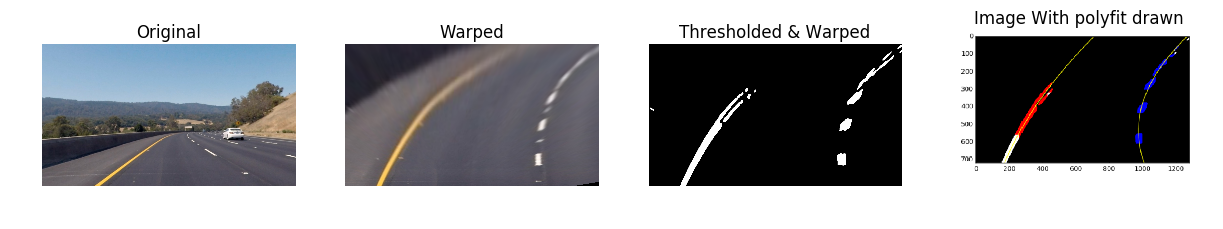

In [74]:
titles = ["Original", "Warped", "Thresholded & Warped", "Image With polyfit drawn"]
images = [image, p.warp(image), p.preprocess(image), mpimg.imread(os.path.join("output_images", "lanedetect.png"))]
helper(images, titles)

This was implemented in line 147 in the images.ipynb notebook file. 

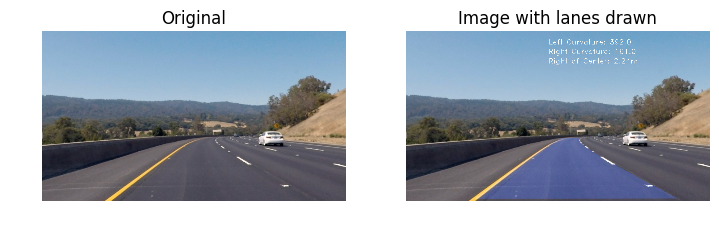

In [78]:
titles = ["Original", "Image with lanes drawn"]
images = [image, mpimg.imread(os.path.join("output_images", "result.jpg"))]
helper(images, titles, size=18)

## Pipeline (Video)


A link to my video - https://youtu.be/6YNffqsGx40

## Discussion

I ran into a lot of problems in this project, I have to say it's been the most challenging project I ever embarked upon and also the most fulfilling. I found the thresholding section the part that took the longest, not only that but it also required going back to it amd fixing to make it more robust, I had no prior experience with CV so felt completely lost at first, It took about a couple weeks to implement the sliding windows and a half decent thresholding working, my biggest regret here is that I had to abandom my sliding windows approach which was to split the image into multiple vertical slices, and detect peaks on the histogram on each slice, I was using the find_peaks function at first but this proved to be extremely slow and so was replaced with numpy's argmax function which did so much better, I then mistakenly saved over the implementation and couldn't get it to work afterwards, luckily this was around the time Udacity released some sample code for detecting lanes, I'm happy I went through figuring out the sliding windows as it enabled me to understand very easily the Udacity implemetation. 


The best part of this project I believe is the thresholding, I feel quite confident that I could, with plenty of hardwork build a threshold to detect in different conditions. 

This pipeline will likely fail the challenge videos for a number of reasons, one is that the perspective transform covers long lanes, this wouldn't work well on roads where we can't see far forward like on an expressway, one of the challenge videos includes twists and turns. I believe this could be solved by capturing shorter lane lines. This pipeline will also likely not work in extreme weather conditions as I believe I tuned it specifically towards the project video. 

I also feel like the video processing isn't fast enough, it takes about 5 minutes to process a 50 second video, this means we can't run this in real time at least not using my system and implementing it the same way, this is something I would like to work on some more. 